In [1]:
from pathlib import Path

import gin
import matplotlib.pyplot as plt
import numpy as np
import torch
from einops import asnumpy, parse_shape, rearrange
from tqdm import tqdm

import dataloaders
import multi_slam.solver.epa_ops as epops
from multi_slam.locnet import LocNet
from multi_slam.utils.misc import clean_state_dict
from multi_slam.utils.drawing import make_matching_plot
from multi_slam.utils.keypoint_extractors import random_keypoints, superpoint_keypoints

In [2]:
# Helper functions

@torch.inference_mode()
def run_model(model, images, intrinsics):
    assert parse_shape(images, 'LR RGB _ _') == dict(LR=2, RGB=3)
    assert parse_shape(intrinsics, 'LR f') == dict(LR=2, f=4)
    fixed_output, model_output = model(images[None], intrinsics[None])
    output = []
    for mo in model_output:
        pts1, pts2 = epops.make_bidir_pts(fixed_output['centroids'], mo['matches']).squeeze(1)
        weights = mo['weight'].flatten()
        output.append([pts1, pts2, weights, mo['poses'].matrix()])
    return output

def show_img(x):
    plt.figure(figsize = (10,10))
    plt.imshow(x)
    plt.axis('off')
    plt.show()

@gin.configurable
def VizDataloader(dl, **kwargs):
    return dl(**kwargs)

In [3]:
gconfigs = [next(iter(Path('gconfigs').rglob(g)), None) for g in (["model/fast.gin", "scannet.gin", "megadepth.gin"])]
assert all(gconfigs) # ensure all .gin files were found

# DATASET = "SN/train" # Uncomment for Scannet training set
DATASET = "SN/test"  # Uncomment for Scannet testing set
# DATASET = "MD/train" # Uncomment for Megadepth training set
# DATASET = "MD/test"  # Uncomment for Megadepth testing set
gin.parse_config_files_and_bindings(gconfigs, [f"VizDataloader.dl = @{DATASET}/DLWrapper"]);

Created Dataloader (Scannet/Test): # Samples-per-epoch: 1,500 (RANK:0 WORLD:1)


Creating visualizations:   0%|          | 0/1500 [00:00<?, ?it/s]

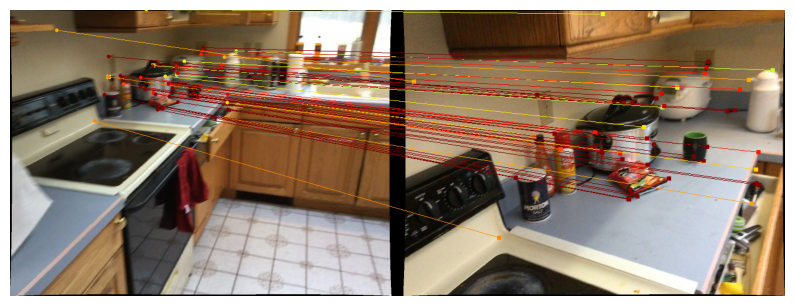

Creating visualizations:   0%|          | 1/1500 [00:00<16:53,  1.48it/s]

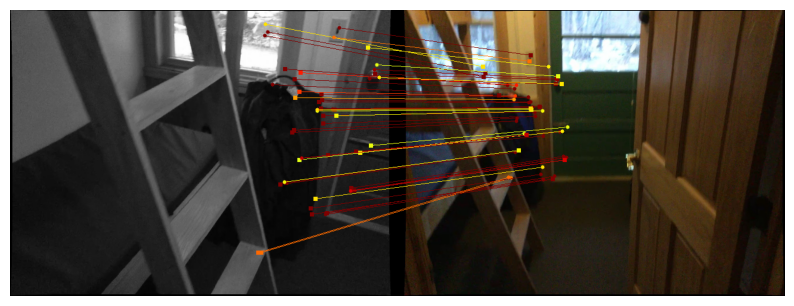

Creating visualizations:   0%|          | 2/1500 [00:00<10:11,  2.45it/s]

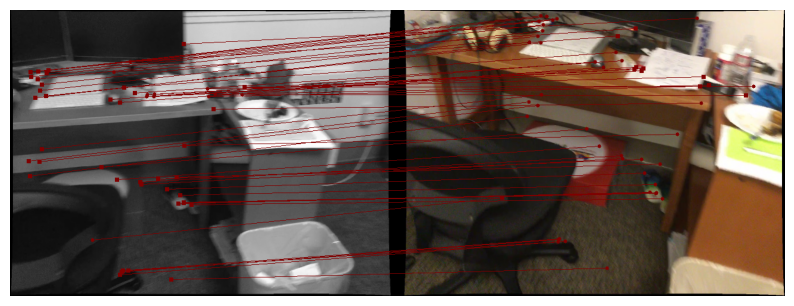

Creating visualizations:   0%|          | 3/1500 [00:01<07:58,  3.13it/s]

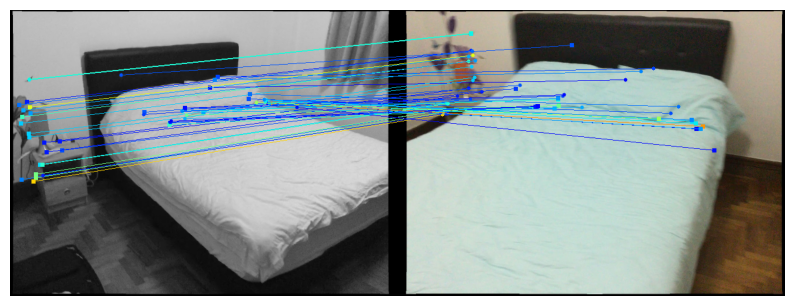

Creating visualizations:   0%|          | 4/1500 [00:01<06:58,  3.57it/s]

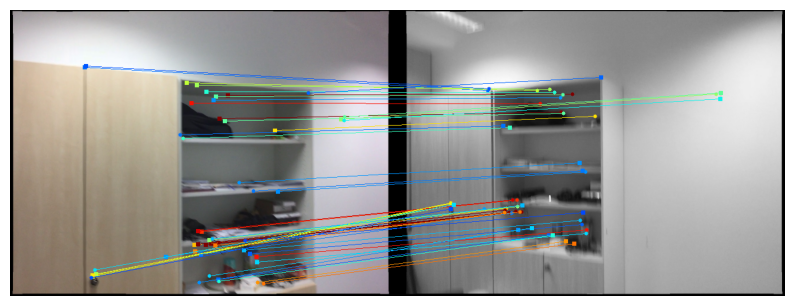

Creating visualizations:   0%|          | 5/1500 [00:01<06:22,  3.91it/s]

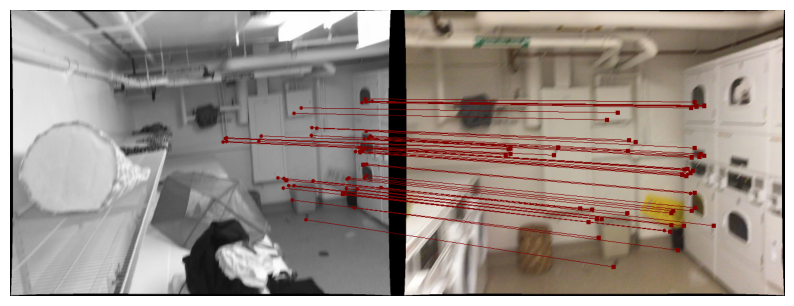

Creating visualizations:   0%|          | 6/1500 [00:01<06:00,  4.15it/s]

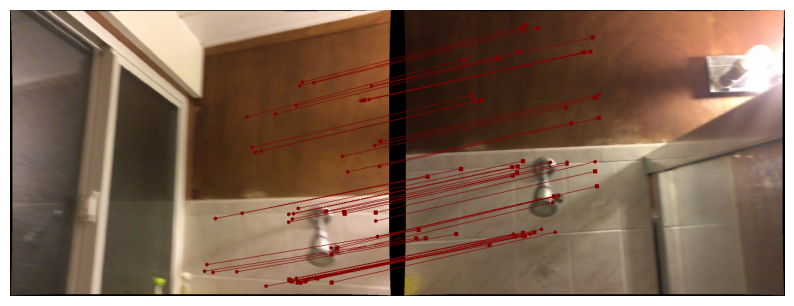

Creating visualizations:   0%|          | 7/1500 [00:01<05:58,  4.16it/s]

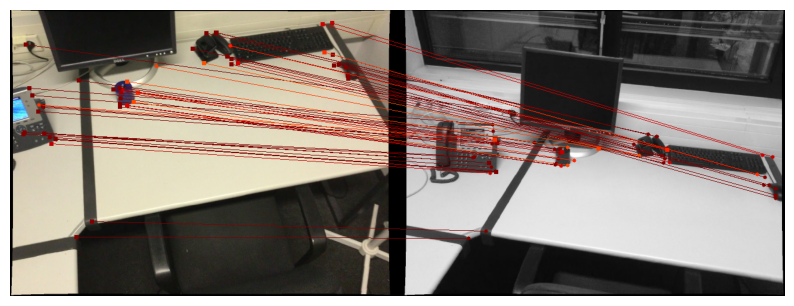

Creating visualizations:   1%|          | 8/1500 [00:02<05:45,  4.31it/s]

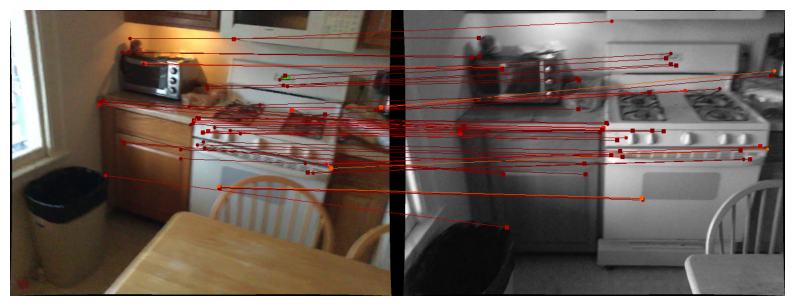

Creating visualizations:   1%|          | 9/1500 [00:02<05:42,  4.36it/s]

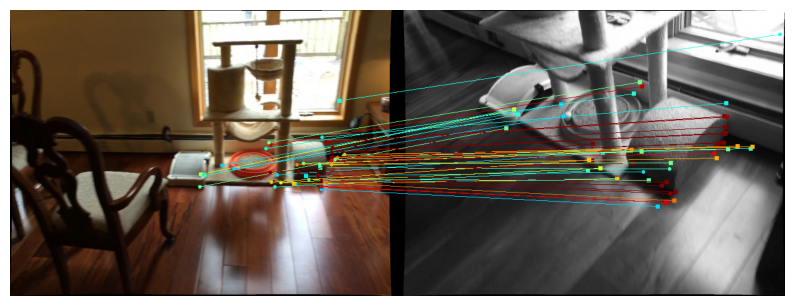

Creating visualizations:   1%|          | 10/1500 [00:02<06:36,  3.76it/s]


In [4]:
model_state = "twoview.pth"

# Set random seed
torch.manual_seed(1234)
np.random.seed(1234)

# Setup model
model = LocNet().cuda().eval()
model.load_state_dict(clean_state_dict(torch.load(model_state)))
# net.compile_modules()

# Setup dataloader
eval_dataloader = VizDataloader(num_workers=6, shuffle=True, batch_size=1)

for batch_index, data_dict in enumerate(tqdm(eval_dataloader, "Creating visualizations")):

    if batch_index >= 10:
        break

    images, intrinsics = data_dict["images"].squeeze(0), data_dict["intrinsics"].squeeze(0)

    predictions = run_model(model, images, intrinsics)

    _, _, final_weights, _ = predictions[-1]
    matches_to_show = asnumpy(final_weights.argsort()[-50:])
    img1, img2 = rearrange(asnumpy(images.byte()), 'LR RGB H W -> LR H W RGB', LR=2, RGB=3)
    for step, (pts1, pts2, weights, pred_pose) in enumerate(predictions[-1:]):
        img = make_matching_plot(None, img1, img2, asnumpy(pts1), asnumpy(pts2), asnumpy(weights) * 3, matches_to_show, text=[])
        show_img(img)